- https://github.com/matt-graham/bvh-tools/tree/master/bvh
- https://github.com/20tab/bvh-python/pull/2/files
- https://github.com/20tab/bvh-python
- https://gist.github.com/johnfredcee/2007503
- https://github.com/ezgitek/bvh-parser/blob/master/bvhparser.py

Papers

- http://theorangeduck.com/media/uploads/other_stuff/phasefunction.pdf
- https://arxiv.org/abs/1605.06921

[BVH preview in browser](http://game.akjava.com/creator/)

initial observations:
- bvh loader doesn't work, but bvh is fairly simple to parse manually
- some channels are actually constant? maybe the end sites?
- the rotations need to be unwrapped in order to be processed.
- how do we deal with people who have different body measurements? only use rotation?
- how do we deal with drift in rotation if we are modeling the relative values instead of absolute?

maybe try using sketch rnn?
- https://github.com/tensorflow/magenta/tree/master/magenta/models/sketch_rnn
- https://github.com/tensorflow/magenta-demos/blob/master/jupyter-notebooks/Sketch_RNN.ipynb

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# load from BVH
parsed = []
names = []
# with open('Take54.bvh') as f:
with open('../tSNEBVH/bin/data/bvh/MotionData-180216/erisa003.bvh') as f:
    for line in f:
        line = line.strip()
        if line.startswith('ROOT') or line.startswith('JOINT'):
            for channel in 'Xposition Yposition Zposition Zrotation Xrotation Yrotation'.split(' '):
                names.append(line + ' ' + channel)
        if line == 'MOTION':
            break
    frames = int(next(f).split(':')[1])
    frame_time = float(next(f).split(':')[1])
    print(frames, frame_time)
    for line in f:
        parsed.append(np.array(line.strip().split(' '), dtype=float))
parsed = np.asarray(parsed)
parsed.shape

43188 0.00833333


(43188, 192)

In [4]:
len(names)

192

In [2]:
parsed = np.loadtxt('../tSNEBVH/bin/data/erisa003-quaternions.tsv', delimiter='\t')
# parsed = np.loadtxt(../tSNEBVH/bin/data/erisa003-absolute-export.tsv', delimiter='\t')
# parsed = np.loadtxt('../tSNEBVH/bin/data/erisa003-relative-export.tsv', delimiter='\t')
# parsed = np.loadtxt('../tSNEBVH/bin/data/Take54-absolute-export.tsv', delimiter='\t')
parsed.shape

(43188, 156)

In [3]:
def normalize(y):
    y -= y.min(axis=0)
    y /= y.max(axis=0)
    return y

In [4]:
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(n_jobs=10)
%time y_tsne = tsne.fit_transform(parsed[::15]) # every 125ms, 8fps

y_tsne = normalize(y_tsne)

ModuleNotFoundError: No module named 'MulticoreTSNE'

In [5]:
import umap
%time y_umap = umap.UMAP().fit_transform(parsed[::15])
y_umap = normalize(y_umap)

ModuleNotFoundError: No module named 'umap'

In [ ]:
np.savetxt('y_tsne.tsv', y_tsne, fmt='%.6f', delimiter='\t')
np.savetxt('y_umap.tsv', y_umap, fmt='%.6f',delimiter='\t')

In [ ]:
def scatter_plot(y):
    plt.figure(figsize=(10,10))
    plt.scatter(y[:,0], y[:,1], s=2, c=range(len(y)), cmap='rainbow')
    plt.show()

scatter_plot(y_umap)
scatter_plot(y_tsne)

In [ ]:
subset = parsed[::15]
subset.shape

In [ ]:
plt.plot(sorted(np.std(subset, axis=0)))
plt.yscale('log')
plt.show()

In [ ]:
to_delete = np.where(np.std(subset, axis=0) < 10e-1)
to_delete

In [ ]:
subset = np.delete(subset, to_delete, axis=1)

In [ ]:
subset -= subset.mean(axis=0) # center
# subset /= subset.std(axis=0) # scale (don't do this for positions, more motion is more significant)
subset /= subset.std() # scale everything down a bit

In [ ]:
plt.plot(subset[:,6])

In [ ]:
%time y_umap_subset = normalize(umap.UMAP().fit_transform(subset))
np.savetxt('pos_rel_umap_subset.tsv', y_umap_subset, fmt='%.6f', delimiter='\t')
scatter_plot(y_umap_subset)

In [ ]:
# subset.shape
subset_d = np.diff(subset, axis=0)
subset_d -= subset_d.mean(axis=0)
subset_d /= subset_d.std()

In [ ]:
%time y_umap_subset_d = normalize(umap.UMAP().fit_transform(subset_d))
np.savetxt('pos_rel_d_umap_subset.tsv', y_umap_subset_d, fmt='%.6f', delimiter='\t')
scatter_plot(y_umap_subset_d)

In [ ]:
tsne = TSNE(n_jobs=10)
%time y_tsne_subset_d = normalize(tsne.fit_transform(subset_d)) # every 125ms, 8fps
np.savetxt('y_tsne_subset_d.tsv', y_tsne_subset_d, fmt='%.6f', delimiter='\t')
scatter_plot(y_tsne_subset_d)

In [ ]:
parsed[:,:9].std(axis=0), parsed[:,:9].mean(axis=0)

In [ ]:
%time y_umap_subset_d = normalize(umap.UMAP().fit_transform(subset_d))
np.savetxt('y_umap_subset_d.tsv', y_umap_subset_d, fmt='%.6f', delimiter='\t')
scatter_plot(y_umap_subset_d)

In [ ]:
plt.figure(figsize=(20,10))
total = 0
for i in range(parsed.shape[1]):
    x = parsed[:,i]
    if np.std(x) < 0.1:# or np.min(x) < -150 or np.max(x) > 150:
        plt.plot(parsed[:,i], label=i)
    else:
        total += 1
#         continue
# plt.legend()
print(total)
plt.show()

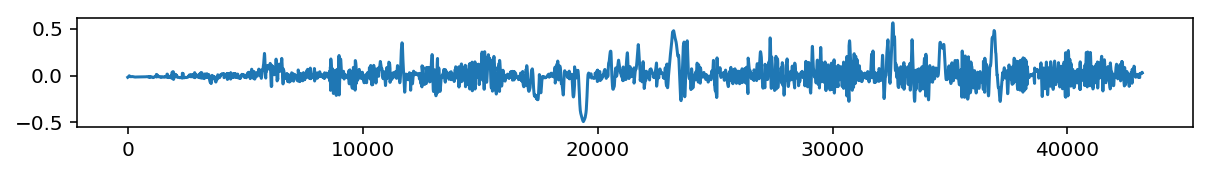

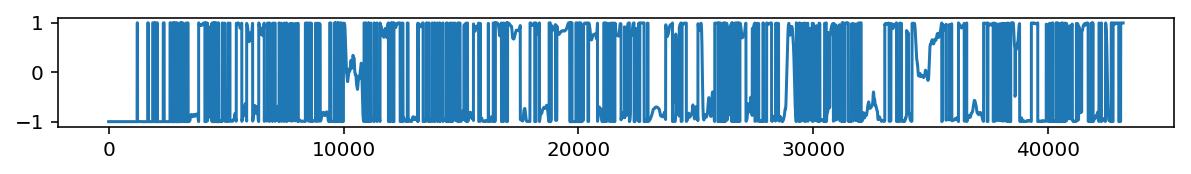

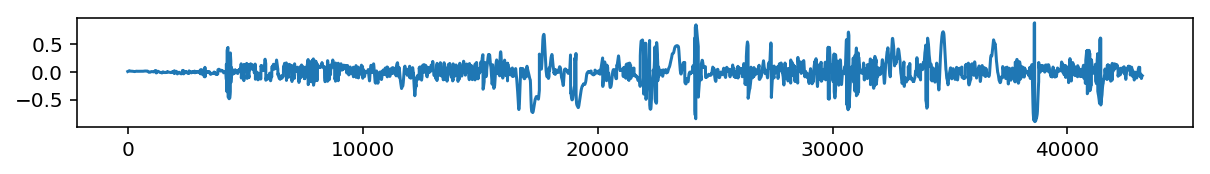

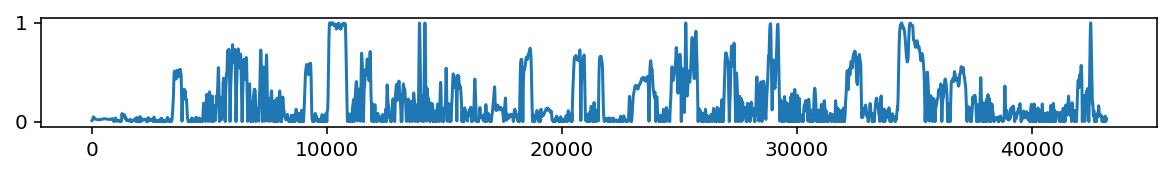

In [25]:
# for i in range(parsed.shape[1]):
for i in range(24,28):
    x = parsed[:,i]
    if np.std(x) < 0.01:# or np.min(x) < -150 or np.max(x) > 150:
        continue
    plt.figure(figsize=(10,1), facecolor='white')
    plt.plot(x)#, label=i)
#     plt.title(names[i])
    plt.show()

In [ ]:
for i in range(parsed.shape[1]):
    x = parsed[:,i]
    if np.std(x) < 0.1:# or np.min(x) < -150 or np.max(x) > 150:
        continue
    plt.figure(figsize=(2,2), facecolor='white')
    plt.hist(x, bins=8)#, label=i)
#     plt.title(names[i])
    plt.show()

In [ ]:
###### plt.figure(figsize=(20,10))
for i in range(parsed.shape[1]):
    x = parsed[:,i]
#     if np.std(x) < 0.1 or 
    if np.min(x) < -150 or np.max(x) > 150:
        unwrapped = np.unwrap(x * (np.pi / 180)) * (180 / np.pi)
#         continue
#         plt.plot(x, label=i)
        plt.plot(unwrapped, label=i)
#         break
plt.show()

In [ ]:
from bvh import Bvh

In [ ]:
with open('Take54.bvh') as f:
    mocap = Bvh(f.read())

In [ ]:
help(mocap)

In [ ]:
[str(item) for item in mocap.root]

In [ ]:
# root offset
next(mocap.root.filter('ROOT'))['OFFSET']

In [ ]:
mocap.get_joints_names()

In [ ]:
# joint offset
mocap.joint_offset('Hips')

In [ ]:
mocap.joint_channels('Hips')

In [ ]:
mocap.frame_joint_channel(0, 'Hips', 'Xposition')

In [ ]:
data = {}
for joint in mocap.get_joints_names():
    print(joint)
    for channel in mocap.joint_channels(joint):
        name = '{}/{}'.format(joint, channel)
        data[name] = [mocap.frame_joint_channel(frame, joint, channel) for frame in range(mocap.nframes)]

In [ ]:
plt.figure(figsize=(20,10))
for key in data:
    if 'rotation' in key:
        continue
    print(key, np.std(data[key]), np.mean(data[key]))
    plt.plot(data[key], label=key)
plt.legend()
plt.show()